Structure of Dataset:
root
 |-- label: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- MalicAcid: double (nullable = true)
 |-- Ash: double (nullable = true)
 |-- Alcalinity: double (nullable = true)
 |-- Magnesium: integer (nullable = true)
 |-- Phenols: double (nullable = true)
 |-- Flavanoids: double (nullable = true)
 |-- NonFlavanoids: double (nullable = true)
 |-- Proanthocyanins: double (nullable = true)
 |-- ColorIntensity: double (nullable = true)
 |-- Hue: double (nullable = true)
 |-- Dilution: double (nullable = true)
 |-- Proline: integer (nullable = true)


First 5 rows:
+-----+-------+---------+----+----------+---------+-------+----------+-------------+---------------+--------------+----+--------+-------+
|label|Alcohol|MalicAcid| Ash|Alcalinity|Magnesium|Phenols|Flavanoids|NonFlavanoids|Proanthocyanins|ColorIntensity| Hue|Dilution|Proline|
+-----+-------+---------+----+----------+---------+-------+----------+-------------+---------------+----------

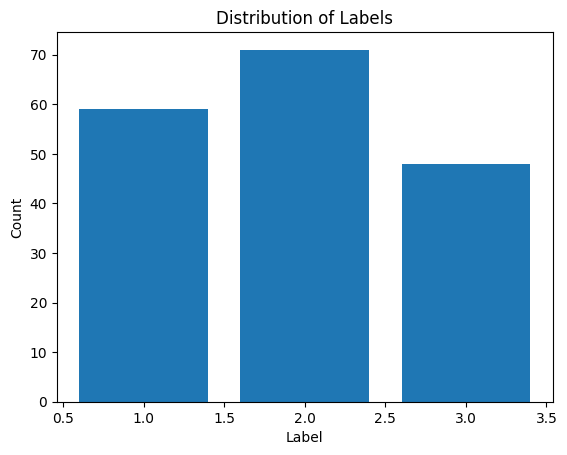

Test RMSE: 0.26
Best Regularization Parameter: 0.1
Best ElasticNet Parameter: 0.0
+-----+------------------+
|label|        prediction|
+-----+------------------+
|    1|1.4606225033474054|
|    1|1.3536832669821797|
|    1|1.0293886594576058|
|    1|1.3821187496215468|
|    1|1.2802700173791814|
+-----+------------------+
only showing top 5 rows



In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt

# 1. Create Spark Session
spark = SparkSession.builder.appName("WineRegression").getOrCreate()

# 2. Load Dataset
data_path = "wine.data"
columns = ["label", "Alcohol", "MalicAcid", "Ash", "Alcalinity", "Magnesium",
           "Phenols", "Flavanoids", "NonFlavanoids", "Proanthocyanins",
           "ColorIntensity", "Hue", "Dilution", "Proline"]

data = spark.read.csv(data_path, header=False, inferSchema=True)
data = data.toDF(*columns)

# 3. Explore Dataset
# Display structure
print("Structure of Dataset:")
data.printSchema()

# Display first few rows
print("\nFirst 5 rows:")
data.show(5)

# Summary statistics
print("\nSummary Statistics:")
data.describe().show()

# Distribution of labels
label_distribution = data.groupBy("label").count()
label_distribution.show()

# Convert to Pandas for plotting
pandas_label_distribution = label_distribution.toPandas()
plt.bar(pandas_label_distribution["label"], pandas_label_distribution["count"])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()

# 4. Prepare Dataset
# Combine feature columns
feature_columns = columns[1:]  # Exclude label
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Split dataset
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# 5. Build Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="label")

# Hyperparameter tuning with Cross-Validation
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Train model
cv_model = cv.fit(train_data)

# 6. Evaluate Model
predictions = cv_model.transform(test_data)
rmse = evaluator.evaluate(predictions)
print(f"Test RMSE: {rmse:.2f}")

# Best model parameters
best_model = cv_model.bestModel
print(f"Best Regularization Parameter: {best_model._java_obj.getRegParam()}")
print(f"Best ElasticNet Parameter: {best_model._java_obj.getElasticNetParam()}")

# 7. Predictions and Evaluation
predictions.select("label", "prediction").show(5)

# Stop Spark Session
spark.stop()
